In [ ]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Cropping the images

import cv2
import numpy as np
import os

def crop_circle(image_path, save_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=20, maxRadius=500)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0][0]  # Assume the largest detected circle

        # Crop the circular region
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

        # Apply the mask
        cropped = cv2.bitwise_and(image, mask)

        # Extract bounding box around the circle
        x1, y1, x2, y2 = x - r, y - r, x + r, y + r
        cropped = cropped[y1:y2, x1:x2]

        cv2.imwrite(save_path, cropped)
        return True

    return False

def process_images(drive_folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for filename in os.listdir(drive_folder_path):
        if filename.lower().endswith(('.tif')):
            image_path = os.path.join(drive_folder_path, filename)
            save_path = os.path.join(save_folder, filename)
            crop_circle(image_path, save_path)

drive_folder_path = "/content/drive/MyDrive/Porosity/Binary"
save_folder = "/content/drive/MyDrive/Porosity/Cropped Binary"

process_images(drive_folder_path, save_folder)

In [ ]:
# loading the pretrained U-Net model in my drive

import tensorflow as tf

model_path = '/content/drive/MyDrive/Porosity DL Project/unet_microstructure_segmentation.h5' # Replace with the actual path

model = tf.keras.models.load_model(model_path)

In [ ]:
import cv2
import numpy as np
import os

# ------------------- Set Paths -------------------
input_folder = "/content/drive/MyDrive/Porosity/Cropped Binary"  # Folder containing binary images

# List to store results
results = []

# Loop through images
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        image_path = os.path.join(input_folder, filename)

        # Load binary image (0 = black, 255 = white)
        binary_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Get image dimensions
        height, width = binary_img.shape
        center = (width // 2, height // 2)
        radius = min(width, height) // 2  # Assuming the circle fits inside the square

        # Create a circular mask
        mask = np.zeros_like(binary_img)
        cv2.circle(mask, center, radius, 255, -1)  # Draw a white circle on a black background

        # Apply the mask to keep only circular region
        circular_region = cv2.bitwise_and(binary_img, mask)

        # Count total pixels inside the circle (both black and white)
        total_pixels_in_circle = np.count_nonzero(mask == 255)

        # Count black pixels (pores) inside the circle
        black_pixels_in_circle = np.count_nonzero((circular_region == 0) & (mask == 255))

        # Calculate porosity percentage
        porosity = (black_pixels_in_circle / total_pixels_in_circle) * 100

        # Store result
        results.append(porosity)


# Compute statistics
if results:
    # Compute statistics
    count_images = len(results)
    min_porosity = min(results)
    max_porosity = max(results)
    mean_porosity = sum(results) / count_images

    # Print final statistics
    print(f"Porosity Statistics:")
    print(f" Total Images: {count_images}")
    print(f" Min Porosity: {min_porosity:.2f}%")
    print(f" Max Porosity: {max_porosity:.2f}%")
    print(f" Mean Porosity: {mean_porosity:.2f}%")
else:
    print("No .tif or .tiff images found in the input folder.")
# Print final statistics
print(f"Porosity Statistics:")
print(f" Total Images: {count_images}")
print(f" Min Porosity: {min_porosity:.2f}%")
print(f" Max Porosity: {max_porosity:.2f}%")
print(f" Mean Porosity: {mean_porosity:.2f}%")

Porosity Statistics:
 Total Images: 1700
 Min Porosity: 0.51%
 Max Porosity: 9.08%
 Mean Porosity: 1.61%
Porosity Statistics:
 Total Images: 1700
 Min Porosity: 0.51%
 Max Porosity: 9.08%
 Mean Porosity: 1.61%


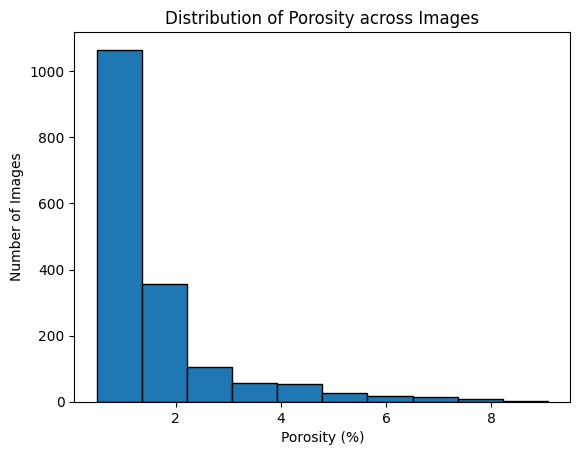

In [ ]:
# Distribution of porosity accross images

import matplotlib.pyplot as plt

# Assuming 'results' list contains the porosity values from the previous code

# Create a histogram of the porosity distribution
plt.hist(results, bins=10, edgecolor='black')  # Adjust 'bins' for desired granularity
plt.xlabel('Porosity (%)')
plt.ylabel('Number of Images')
plt.title('Distribution of Porosity across Images')
plt.show()
